In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'economic'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(71951, 7)
CPU times: user 10.9 s, sys: 158 ms, total: 11 s
Wall time: 11.1 s


In [4]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/imf/,NaN,Россия,МВФ требует от Центробанка закрыть зарубежные ...,Получение финансовой помощи от МВФ станет для ...,Экономика
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nds/,NaN,Россия,"Госдума изменила ставки НДС, несмотря на возра...","На своем пятничном заседании Госдума, несмотря...",Экономика


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 292 ms, sys: 7.87 ms, total: 300 ms
Wall time: 299 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 12.8 s, sys: 114 ms, total: 12.9 s
Wall time: 12.9 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/imf/,NaN,Россия,МВФ требует от Центробанка закрыть зарубежные ...,получение финансовой помощи от мвф станет для ...,Экономика,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nds/,NaN,Россия,"Госдума изменила ставки НДС, несмотря на возра...",на своем пятничном заседании госдума несмотря ...,Экономика,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 2min 12s, sys: 6.01 ms, total: 2min 12s
Wall time: 2min 12s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 59s, sys: 208 ms, total: 3min
Wall time: 3min


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[получение, финансовый, помощь, мвф, россия, з..."
1,1,1999,10,"[пятничный, заседание, госдума, несмотря, возр..."


In [14]:
print(df.shape)
df.isnull().sum()

(71951, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 879 ms, sys: 144 ms, total: 1.02 s
Wall time: 1.09 s


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/economic", num_batches=72)
CPU times: user 33.3 s, sys: 776 ms, total: 34.1 s
Wall time: 8.45 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=d99b1e78-c68a-4e32-8454-8ca8caf6bbd8, num_entries=22163)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [21]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.750196635723114
	SparsityPhiScore: 0.7934214472770691
	PerplexityScore: 1759.3785400390625


---

### print top words for each topics

In [22]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['продукция' 'пошлина' 'товар' 'ввести' 'санкция' 'таможенный' 'запрет'
 'вто' 'импорт' 'ограничение']
topic_1: ['юкос' 'иск' 'подать' 'нарушение' 'претензия' 'бывший' 'арбитражный'
 'штраф' 'судебный' 'признать']
topic_2: ['сеть' 'оператор' 'магазин' 'сотовый' 'производитель' 'бренд' 'торговый'
 'мтс' 'мобильный' 'продукт']
topic_3: ['карта' 'тариф' 'фас' 'услуга' 'ржд' 'почта' 'антимонопольный' 'служба'
 'платёжный' 'дорога']
topic_4: ['кредит' 'долг' 'задолженность' 'облигация' 'мвф' 'помощь' 'финансы'
 'кредитор' 'минфин' 'программа']
topic_5: ['украина' 'пенсионный' 'украинский' 'пенсия' 'киев' 'нафтогаз' 'гривна'
 'накопление' 'нафтогаза' 'накопительный']
topic_6: ['цб' 'сбербанк' 'кредитный' 'банковский' 'вклад' 'лицензия' 'центробанк'
 'капитал' 'регулятор' 'операция']
topic_7: ['место' 'зарплата' 'россиянин' 'население' 'рейтинг' 'исследование'
 'доход' 'труд' 'средний' 'состояние']
topic_8: ['bank' 'британский' 'фунт' 'великобритания' 'сотрудник' 'убыток'
 'корпораци

In [33]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [34]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['продукция', 'пошлина', 'товар', 'ввести', 'санкция', 'таможенный',
        'запрет', 'вто', 'импорт', 'ограничение', 'торговля', 'торговый',
        'экспорт', 'производитель', 'союз', 'мера', 'продукт', 'ввоз',
        'производство', 'белоруссия'], dtype=object),
 'topic_1': array(['юкос', 'иск', 'подать', 'нарушение', 'претензия', 'бывший',
        'арбитражный', 'штраф', 'судебный', 'признать', 'уголовный',
        'обвинение', 'банкротство', 'монета', 'арест', 'требование',
        'расследование', 'заявление', 'действие', 'деньга'], dtype=object),
 'topic_2': array(['сеть', 'оператор', 'магазин', 'сотовый', 'производитель', 'бренд',
        'торговый', 'мтс', 'мобильный', 'продукт', 'абонент', 'реклама',
        'телефон', 'марка', 'питание', 'apple', 'вымпелком', 'мегафон',
        'товар', 'молоко'], dtype=object),
 'topic_3': array(['карта', 'тариф', 'фас', 'услуга', 'ржд', 'почта',
        'антимонопольный', 'служба', 'платёжный', 'дорога', 'крым',
       

### get topics-docs matrix

shape theta: (20, 71942)


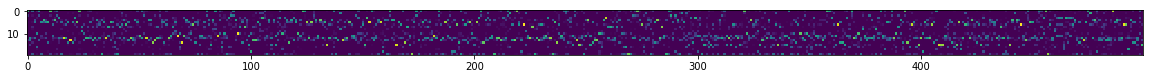

In [23]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [24]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
57000,0.070265,0.0,0.000000,0.000000,0.467589,0.000000,0.000000,0.000000,0.0,0.429073,0.0,0.000000,0.033073,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
57001,0.000000,0.0,0.000000,0.000000,0.092849,0.664637,0.016302,0.000000,0.0,0.000000,0.0,0.000000,0.012000,0.214211,0.000000,0.0,0.000000,0.0,0.000000,0.000000
57002,0.000000,0.0,0.038313,0.000000,0.000000,0.082135,0.000000,0.176692,0.0,0.000000,0.0,0.129851,0.347236,0.000000,0.000000,0.0,0.000000,0.0,0.205171,0.020601
57003,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.014342,0.876139,0.0,0.004061,0.0,0.000000,0.105459
57004,0.000000,0.0,0.000000,0.494342,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.341330,0.000000,0.0,0.000000,0.0,0.164328,0.000000


## DataViz

In [25]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.164917,0.000000,0.0,0.437899,0.0,0.13947,...,0.000000,0.0,0.000000,0.070811,0.0,0.0,0.000000,0.000000,0.0,0.186902
1,1,1999,10,0.191934,0.000000,0.147292,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.019243,0.617746,0.0,0.0,0.000000,0.023785,0.0,0.000000
2,2,1999,10,0.000000,0.057252,0.000000,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.010532,0.000000,0.0,0.631098
3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.265110,0.0,0.00000,...,0.164503,0.0,0.394995,0.000000,0.0,0.0,0.000000,0.175393,0.0,0.000000
4,4,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,...,0.273122,0.0,0.000000,0.000000,0.0,0.0,0.045125,0.000000,0.0,0.153230


In [26]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0    topic_1   topic_2   topic_3    topic_4   topic_5  \
year month                                                                  
1999 8       0.360621   0.215711  0.084377  0.045643   0.635141  0.007148   
     9       3.430229   5.899933  1.284795  1.385079   6.591860  0.881341   
     10      6.426537   9.703101  4.942524  3.308285   8.983451  1.377776   
     11     11.460155  11.583758  5.492241  4.160614  11.386721  3.438186   
     12      5.270871   8.334826  4.207441  4.505254   9.258125  1.163870   

             topic_6   topic_7    topic_8   topic_9   topic_10  topic_11  \
year month                                                                 
1999 8      0.000000  0.000000   0.055226  0.000000   0.365486  0.000000   
     9      2.052577  1.692480   3.840857  0.934993   5.001811  4.068701   
     10     3.851482  4.312931  11.041775  2.189018  14.714955  4.896838   
     11     2.722995  3.308853   7.408444  2.668801   9.983951  1.659486   
     12     3.023205  1.057798   4.295572  0.870167   4.952673  4.904574   

            topic_12   topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                                
1999 8      0.042694   0.346132  0.000000  0.041352  0.343160  0.000000   
     9      1.956223   8.213521  1.048859  2.415576  1.617712  3.344845   
     10     5.811186  11.714668  4.506484  5.943307  3.491746  2.294420   
     11     4.952374  19.614573  5.930966  4.637858  5.024067  2.571866   
     12     2.522338   9.086765  3.066147  1.372384  0.854947  1.369057   

            topic_18   topic_19  
year month                       
1999 8      0.083004   0.374304  
     9      1.420895   8.917713  
     10     2.619562   8.869957  
     11     1.578125  13.415964  
     12     1.106419   7.777565

### straightforward matrix heatmap

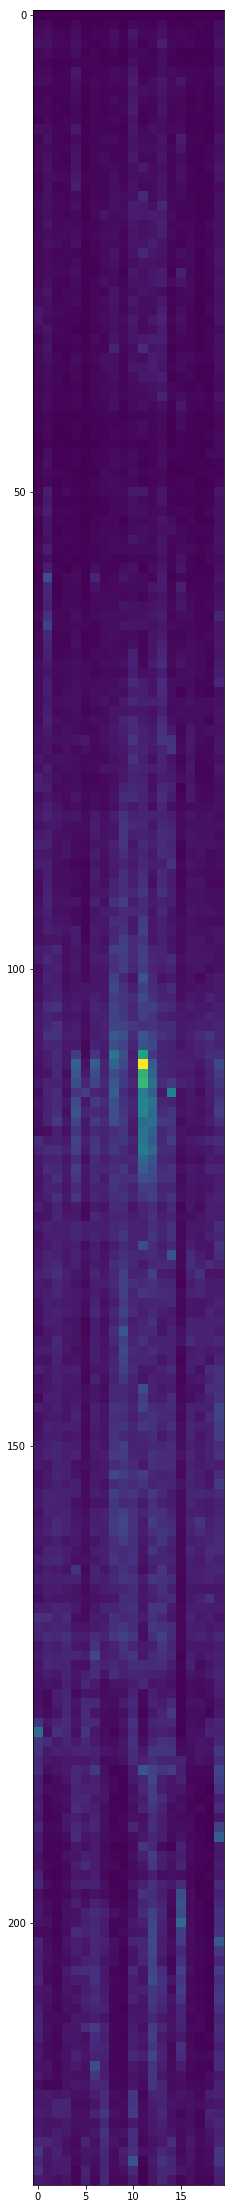

In [27]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [32]:
import pygal
from IPython.display import SVG, HTML

In [33]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [34]:
max(gb['topic_1'].values)

51.66977

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [46]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [37]:
import joypy # !pip install joypy

In [28]:
print(joined.shape)
joined.head()

(71951, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.164917,0.000000,0.0,0.437899,0.0,0.13947,...,0.000000,0.0,0.000000,0.070811,0.0,0.0,0.000000,0.000000,0.0,0.186902
1,1,1999,10,0.191934,0.000000,0.147292,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.019243,0.617746,0.0,0.0,0.000000,0.023785,0.0,0.000000
2,2,1999,10,0.000000,0.057252,0.000000,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.010532,0.000000,0.0,0.631098
3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.265110,0.0,0.00000,...,0.164503,0.0,0.394995,0.000000,0.0,0.0,0.000000,0.175393,0.0,0.000000
4,4,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,...,0.273122,0.0,0.000000,0.000000,0.0,0.0,0.045125,0.000000,0.0,0.153230


In [29]:
joined.to_csv(f'''./data/topicsProbability/{'-'.join(name_dataset.split('.'))}.csv''',index=False)

In [39]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,1999,10,0.0,0.131378,0.000000,0.000000,0.467102,0.011317,0.145951,...,0.000000,0.000000,0.086179,0.000000,0.000000,0.012817,0.000000,0.0,0.078840,1999-10-01
1,1,1999,10,0.0,0.027198,0.284482,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.597932,0.000000,0.053999,0.000000,0.036389,0.0,0.000000,1999-10-01
2,2,1999,10,0.0,0.134164,0.000000,0.000000,0.226240,0.000000,0.000000,...,0.011545,0.000000,0.000000,0.000000,0.000000,0.020124,0.000000,0.0,0.214232,1999-10-01
3,3,1999,10,0.0,0.155311,0.033279,0.000000,0.247659,0.000000,0.000000,...,0.000000,0.171425,0.000000,0.000000,0.000000,0.000000,0.228688,0.0,0.000000,1999-10-01
4,4,1999,10,0.0,0.000000,0.000000,0.127365,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.085701,0.000000,0.011750,0.000000,0.0,0.124774,1999-10-01


In [40]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
5,1999-10-01,topic_0,0.101650
7,1999-10-01,topic_0,0.128152
8,1999-10-01,topic_0,0.056796
13,1999-10-01,topic_0,0.128775
15,1999-10-01,topic_0,0.050602


In [41]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic             
1999-08-01 topic_0   0.133623
           topic_1   0.280046
           topic_10  0.137270
           topic_11  0.009803
           topic_12  0.076553

In [42]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,1999-08-01,topic_0,0.133623
1,1999-08-01,topic_1,0.280046
2,1999-08-01,topic_10,0.137270
3,1999-08-01,topic_11,0.009803
4,1999-08-01,topic_12,0.076553


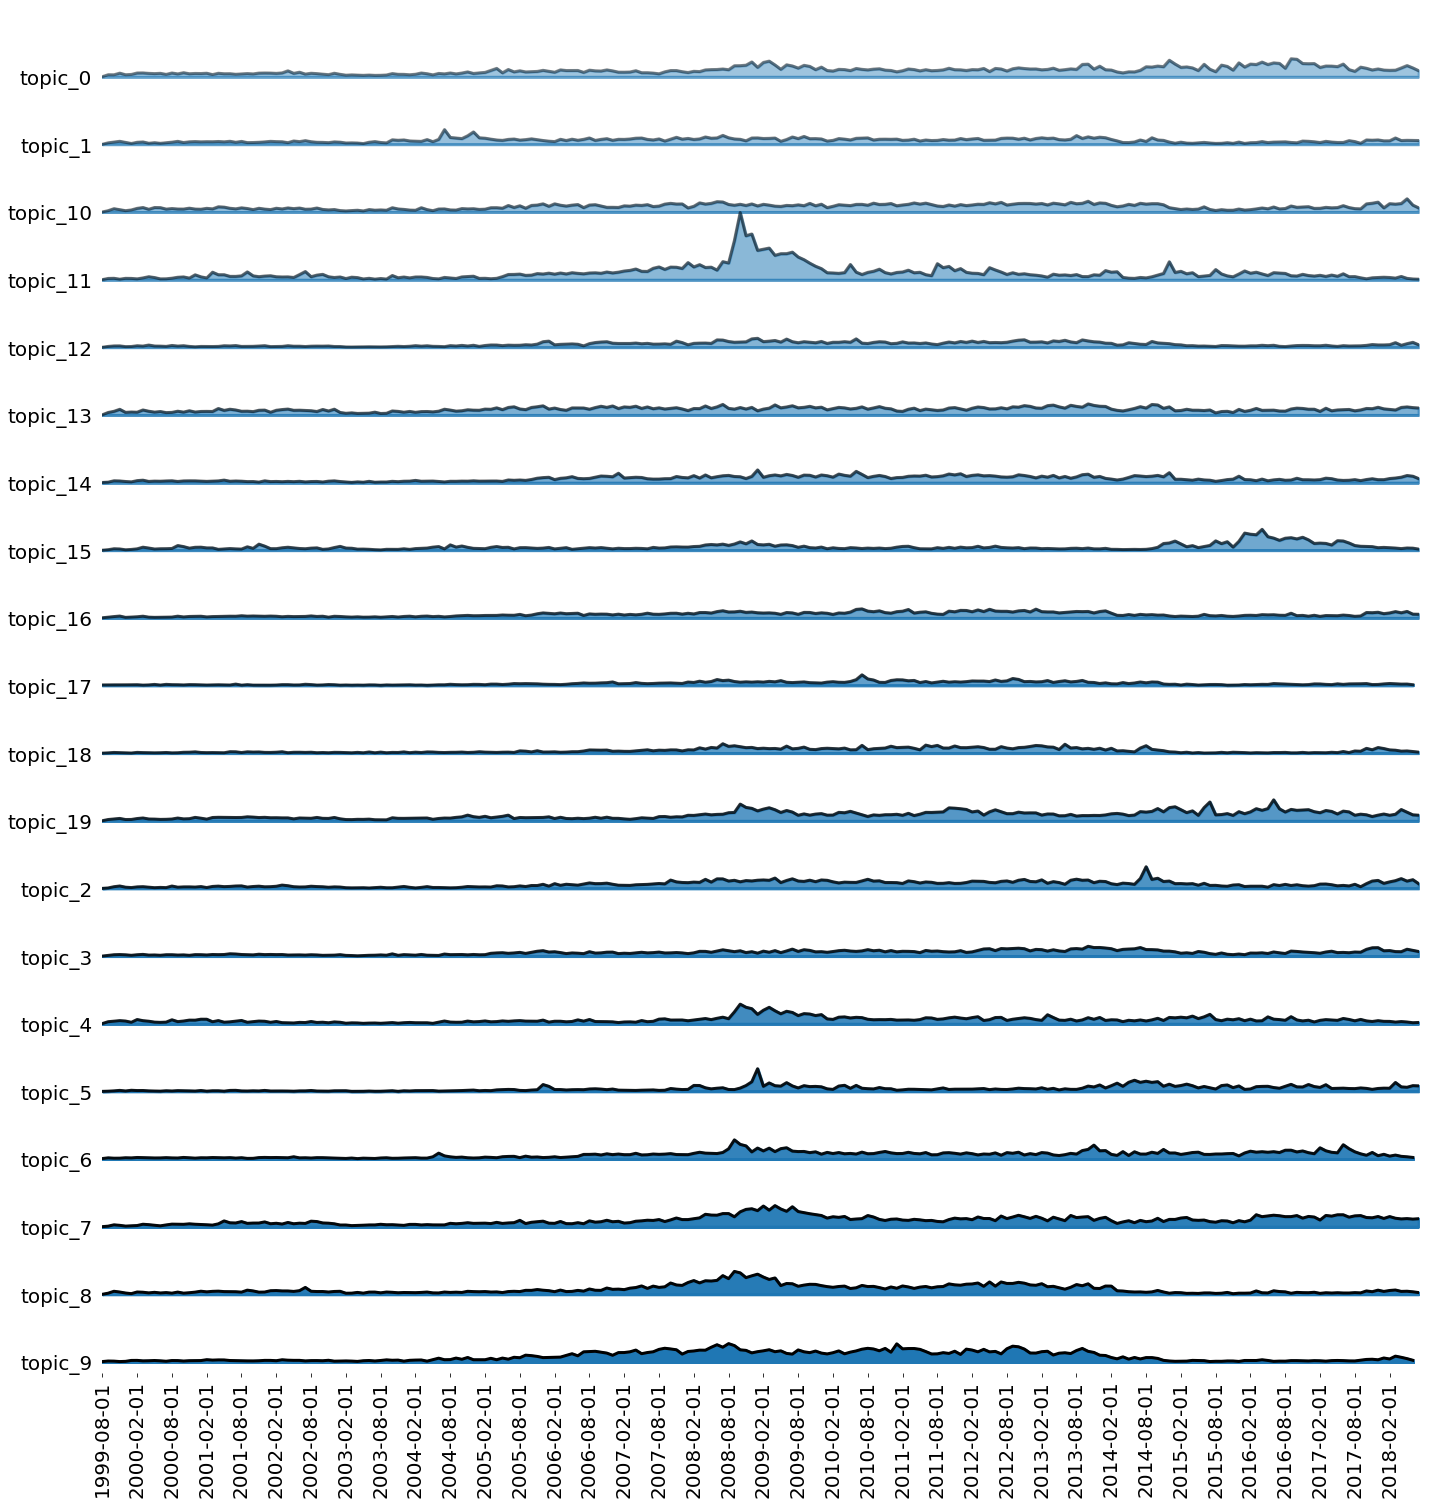

In [43]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [45]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")